#Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as plt
import sqlite3 as sql
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Tratamento Inicial dos Dados Brutos

In [3]:
Ibovespa = pd.read_csv('/content/Dados Históricos - Ibovespa.csv')
Ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,10.07.2025,136.743,137.472,137.472,136.014,"9,57M","-0,54%"
1,09.07.2025,137.481,139.303,139.331,137.299,"7,58B","-1,31%"
2,08.07.2025,139.303,139.491,139.591,138.770,"6,75B","-0,13%"
3,07.07.2025,139.490,141.265,141.342,139.295,"6,12B","-1,26%"
4,04.07.2025,141.264,140.928,141.564,140.597,"3,31B","0,24%"
...,...,...,...,...,...,...,...
4949,15.07.2005,25.222,25.916,25.916,25.222,"72,88M","-2,69%"
4950,14.07.2005,25.920,25.859,26.142,25.725,"113,35M","0,25%"
4951,13.07.2005,25.856,25.557,26.043,25.557,"107,28M","1,25%"
4952,12.07.2005,25.536,25.027,25.576,24.932,"94,91M","2,08%"


In [4]:
# Tratando as Datas, para podermos trabalhar o modelo com base nos dias
Ibovespa['Data'] = pd.to_datetime(Ibovespa['Data'], format='%d.%m.%Y')
Ibovespa = Ibovespa.sort_values(by='Data', ascending=True).reset_index(drop=True)
Ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2005-07-11,25.016,24.425,25.032,24.425,"100,42M","2,43%"
1,2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%"
2,2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%"
3,2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%"
4,2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%"
...,...,...,...,...,...,...,...
4949,2025-07-04,141.264,140.928,141.564,140.597,"3,31B","0,24%"
4950,2025-07-07,139.490,141.265,141.342,139.295,"6,12B","-1,26%"
4951,2025-07-08,139.303,139.491,139.591,138.770,"6,75B","-0,13%"
4952,2025-07-09,137.481,139.303,139.331,137.299,"7,58B","-1,31%"


In [5]:
Ibovespa['Vol.'].unique()

array(['100,42M', '94,91M', '107,28M', ..., '6,12B', '6,75B', '7,58B'],
      dtype=object)

In [6]:
#Criando uma Coluna para separa o Volume -  milhoes e bilhoes - em colunas diferentes. Eu realmente nao sei se o volume é estatisticamente significante para o modelo, entao vale a pena deixar organizado
#Criando as colunas
Ibovespa['Milhoes'] = 0.0
Ibovespa['Bilhoes'] = 0.0
for index, row in Ibovespa.iterrows():
    volume_str = str(row['Vol.'])
    if 'M' in volume_str:
        # Remover 'M', substituir "," por "."", converter em float
        value = float(volume_str.replace('M', '').replace(',', '.'))
        Ibovespa.loc[index, 'Milhoes'] = value
    elif 'B' in volume_str:
        # Remover 'B',  substituir "," por "."", converter em float
        value = float(volume_str.replace('B', '').replace(',', '.'))
        Ibovespa.loc[index, 'Bilhoes'] = value

Ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Milhoes,Bilhoes
0,2005-07-11,25.016,24.425,25.032,24.425,"100,42M","2,43%",100.42,0.00
1,2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%",94.91,0.00
2,2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%",107.28,0.00
3,2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%",113.35,0.00
4,2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%",72.88,0.00
...,...,...,...,...,...,...,...,...,...
4949,2025-07-04,141.264,140.928,141.564,140.597,"3,31B","0,24%",0.00,3.31
4950,2025-07-07,139.490,141.265,141.342,139.295,"6,12B","-1,26%",0.00,6.12
4951,2025-07-08,139.303,139.491,139.591,138.770,"6,75B","-0,13%",0.00,6.75
4952,2025-07-09,137.481,139.303,139.331,137.299,"7,58B","-1,31%",0.00,7.58


In [7]:
#Calculando a variação do dia anterior
Ibovespa['Fechamento_Amanha'] = Ibovespa['Último'].shift(1)
Ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Milhoes,Bilhoes,Fechamento_Amanha
0,2005-07-11,25.016,24.425,25.032,24.425,"100,42M","2,43%",100.42,0.00,NaN
1,2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%",94.91,0.00,25.016
2,2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%",107.28,0.00,25.536
3,2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%",113.35,0.00,25.856
4,2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%",72.88,0.00,25.920
...,...,...,...,...,...,...,...,...,...,...
4949,2025-07-04,141.264,140.928,141.564,140.597,"3,31B","0,24%",0.00,3.31,140.928
4950,2025-07-07,139.490,141.265,141.342,139.295,"6,12B","-1,26%",0.00,6.12,141.264
4951,2025-07-08,139.303,139.491,139.591,138.770,"6,75B","-0,13%",0.00,6.75,139.490
4952,2025-07-09,137.481,139.303,139.331,137.299,"7,58B","-1,31%",0.00,7.58,139.303


In [8]:
#Criando a coluna 'Tendência_Fechamento'
Ibovespa_cleaned = Ibovespa.dropna(subset=['Fechamento_Amanha']).copy()
Ibovespa_cleaned['Tendência_Fechamento'] = (Ibovespa_cleaned['Fechamento_Amanha'] > Ibovespa_cleaned['Último']).astype(int)
Ibovespa = Ibovespa_cleaned
Ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Milhoes,Bilhoes,Fechamento_Amanha,Tendência_Fechamento
1,2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%",94.91,0.00,25.016,0
2,2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%",107.28,0.00,25.536,0
3,2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%",113.35,0.00,25.856,0
4,2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%",72.88,0.00,25.920,1
5,2005-07-18,25.321,25.222,25.412,24.916,"52,17M","0,39%",52.17,0.00,25.222,0
...,...,...,...,...,...,...,...,...,...,...,...
4949,2025-07-04,141.264,140.928,141.564,140.597,"3,31B","0,24%",0.00,3.31,140.928,0
4950,2025-07-07,139.490,141.265,141.342,139.295,"6,12B","-1,26%",0.00,6.12,141.264,1
4951,2025-07-08,139.303,139.491,139.591,138.770,"6,75B","-0,13%",0.00,6.75,139.490,1
4952,2025-07-09,137.481,139.303,139.331,137.299,"7,58B","-1,31%",0.00,7.58,139.303,1


In [9]:
#Filtrando apenas as colunas necessarias para ver o que dá
df = (
    Ibovespa
    .rename(columns= {"Máxima": "Maxima", "Mínima": "Minima", "Último": "Fechamento", "Tendência_Fechamento":"Tendencia"})
    .filter(items=['Data','Fechamento', 'Abertura', 'Maxima', 'Minima', 'Milhoes', 'Bilhoes', 'Tendencia'])
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4953 entries, 1 to 4953
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Data        4953 non-null   datetime64[ns]
 1   Fechamento  4953 non-null   float64       
 2   Abertura    4953 non-null   float64       
 3   Maxima      4953 non-null   float64       
 4   Minima      4953 non-null   float64       
 5   Milhoes     4953 non-null   float64       
 6   Bilhoes     4953 non-null   float64       
 7   Tendencia   4953 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 348.3 KB


In [10]:
#Trabalhando a coluna milhoes, multiplicando todas as linhas por 1000000
df['Milhoes'] = df['Milhoes']*1000000
df.head()

,Data,Fechamento,Abertura,Maxima,Minima,Milhoes,Bilhoes,Tendencia
1,2005-07-12,25.536,25.027,25.576,24.932,94910000.0,0.0,0
2,2005-07-13,25.856,25.557,26.043,25.557,107280000.0,0.0,0
3,2005-07-14,25.920,25.859,26.142,25.725,113350000.0,0.0,0
4,2005-07-15,25.222,25.916,25.916,25.222,72880000.0,0.0,1
5,2005-07-18,25.321,25.222,25.412,24.916,52170000.0,0.0,0


In [11]:
#Trabalhando a coluna bilhoes, multiplicando todas as linhas por 1000000000
df['Bilhoes'] = df['Bilhoes']*1000000000
df.head()

,Data,Fechamento,Abertura,Maxima,Minima,Milhoes,Bilhoes,Tendencia
1,2005-07-12,25.536,25.027,25.576,24.932,94910000.0,0.0,0
2,2005-07-13,25.856,25.557,26.043,25.557,107280000.0,0.0,0
3,2005-07-14,25.920,25.859,26.142,25.725,113350000.0,0.0,0
4,2005-07-15,25.222,25.916,25.916,25.222,72880000.0,0.0,1
5,2005-07-18,25.321,25.222,25.412,24.916,52170000.0,0.0,0


In [12]:
#Utilizando um join para juntar as colunas, e criando uma unica coluna chamada "Volume"
df['Volume'] = df['Milhoes'] + df['Bilhoes']
df.head()

,Data,Fechamento,Abertura,Maxima,Minima,Milhoes,Bilhoes,Tendencia,Volume
1,2005-07-12,25.536,25.027,25.576,24.932,94910000.0,0.0,0,94910000.0
2,2005-07-13,25.856,25.557,26.043,25.557,107280000.0,0.0,0,107280000.0
3,2005-07-14,25.920,25.859,26.142,25.725,113350000.0,0.0,0,113350000.0
4,2005-07-15,25.222,25.916,25.916,25.222,72880000.0,0.0,1,72880000.0
5,2005-07-18,25.321,25.222,25.412,24.916,52170000.0,0.0,0,52170000.0


In [13]:
#Excluindo as colunas Milhoes e Bilhoes
df = df.drop(['Milhoes', 'Bilhoes'], axis=1)
df.head()

,Data,Fechamento,Abertura,Maxima,Minima,Tendencia,Volume
1,2005-07-12,25.536,25.027,25.576,24.932,0,94910000.0
2,2005-07-13,25.856,25.557,26.043,25.557,0,107280000.0
3,2005-07-14,25.920,25.859,26.142,25.725,0,113350000.0
4,2005-07-15,25.222,25.916,25.916,25.222,1,72880000.0
5,2005-07-18,25.321,25.222,25.412,24.916,0,52170000.0


In [14]:
#Estabelecendo a coluna data como indice
df = df.set_index('Data')
df.head()

,Fechamento,Abertura,Maxima,Minima,Tendencia,Volume
Data,,,,,,
2005-07-12,25.536,25.027,25.576,24.932,0,94910000.0
2005-07-13,25.856,25.557,26.043,25.557,0,107280000.0
2005-07-14,25.920,25.859,26.142,25.725,0,113350000.0
2005-07-15,25.222,25.916,25.916,25.222,1,72880000.0
2005-07-18,25.321,25.222,25.412,24.916,0,52170000.0


#Normalzando os Valores de Abertura, Fechamento e Volume

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(df[['Fechamento']])
df[['Fechamento']] = scaled_df
scaled_df1 = scaler.fit_transform(df[['Abertura']])
df[['Abertura']] = scaled_df1
scaled_df2 = scaler.fit_transform(df[['Volume']])
df[['Volume']] = scaled_df2
scaled_df3 = scaler.fit_transform(df[['Maxima']])
df[['Maxima']] = scaled_df3
scaled_df4= scaler.fit_transform(df[['Minima']])
df[['Minima']] = scaled_df4
df.tail()
#para retornar os valores ao original utilizar a funcao scaler.inverse_transform(scaleed_df)

,Fechamento,Abertura,Maxima,Minima,Tendencia,Volume
Data,,,,,,
2025-07-04,1.000000,0.997114,1.000000,1.000000,0,0.133092
2025-07-07,0.984803,1.000000,0.998097,0.988802,1,0.246080
2025-07-08,0.983201,0.984806,0.983088,0.984286,1,0.271411
2025-07-09,0.967593,0.983196,0.980860,0.971635,1,0.304785
2025-07-10,0.961271,0.967514,0.964925,0.960583,1,0.000385


In [96]:
#Reorganizando a ordem das colunas, para que a coluna Tendencia fique por ultimo
df = df[[ 'Fechamento','Abertura', 'Maxima', 'Minima', 'Volume', 'Tendencia']]
df.head()

,Fechamento,Abertura,Maxima,Minima,Volume,Tendencia
Data,,,,,,
2005-07-12,0.008609,0.004462,0.005803,0.005195,0.003816,0
2005-07-13,0.011351,0.009001,0.009806,0.010570,0.004314,0
2005-07-14,0.011899,0.011588,0.010654,0.012015,0.004558,0
2005-07-15,0.005919,0.012076,0.008717,0.007689,0.002930,1
2005-07-18,0.006768,0.006132,0.004397,0.005057,0.002098,0


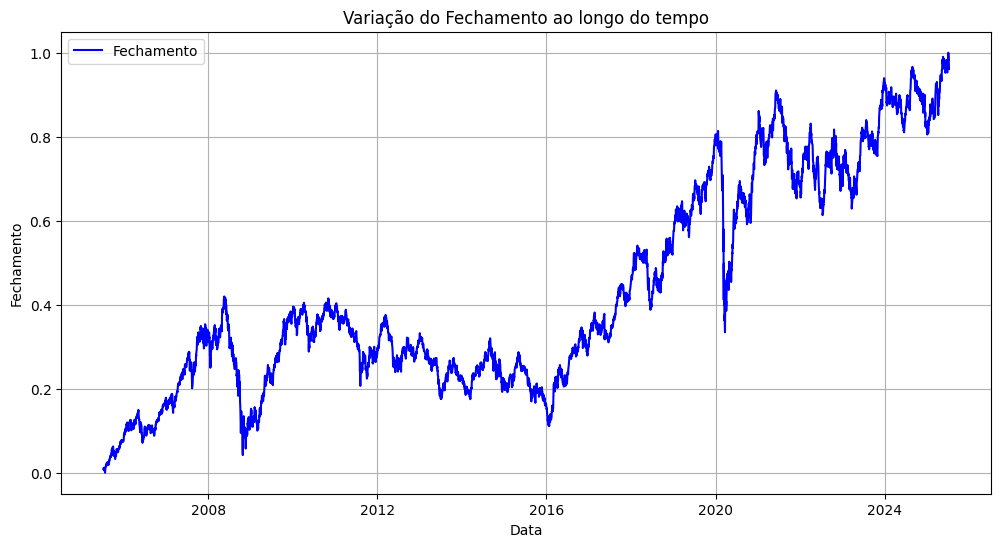

In [98]:
#Plotando o Fechamento no tempo
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Fechamento'], label='Fechamento', color='blue')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.title('Variação do Fechamento ao longo do tempo')
plt.legend()
plt.grid(True)
plt.show()


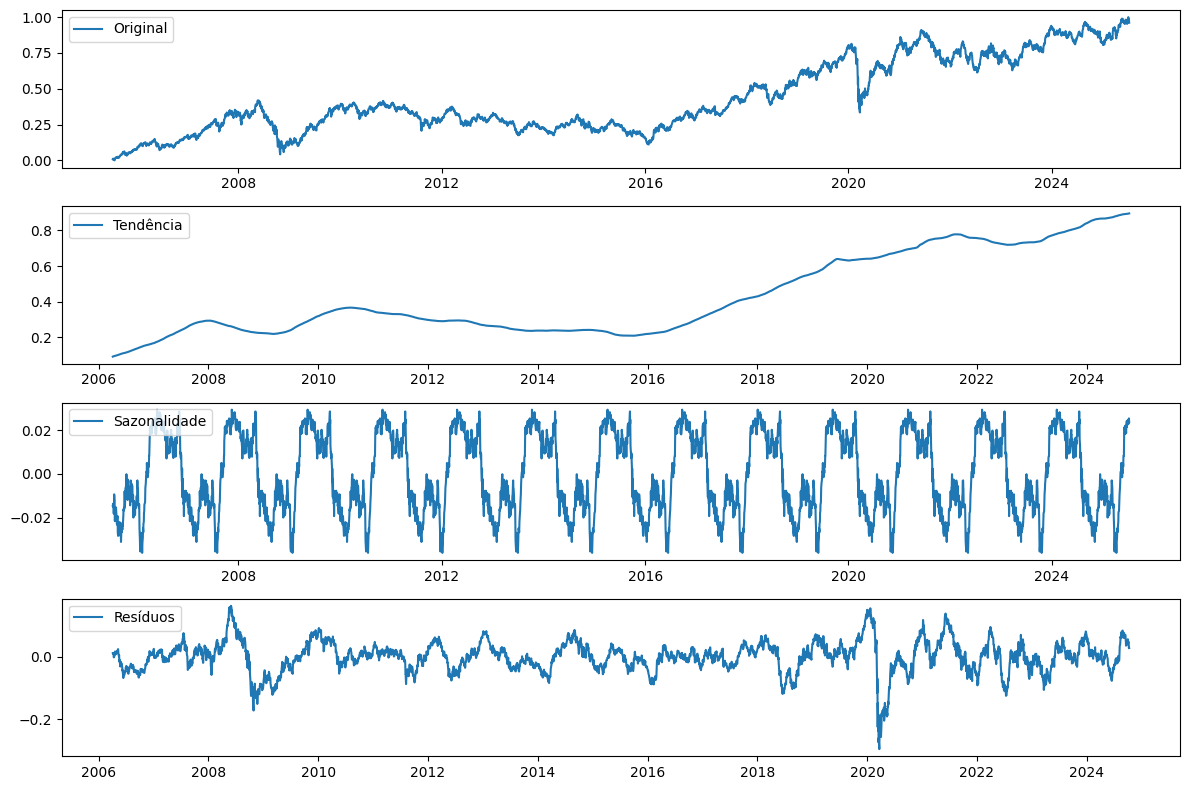

In [100]:
#Retirando a sazonaldiade da série
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Fechamento'], model='additive', period=365)
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df.index, df['Fechamento'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(df.index, result.trend, label='Tendência')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(df.index, result.seasonal, label='Sazonalidade')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(df.index, result.resid, label='Resíduos')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [97]:
#Dividindo o Dataset para tratamento
x = df.drop('Tendencia', axis=1)
y = df['Tendencia']
#Identificando a proporção dos processos em que houve pagamento, para identificar o balanceamento
y.value_counts()

,count
Tendencia,
0,2577
1,2376


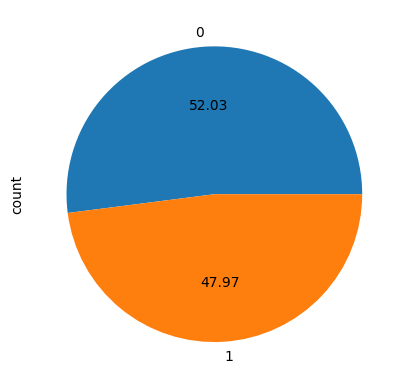

In [18]:
#Plotando um gráfico para ver visualmente a diferença, em termos de proproção
y.value_counts().plot.pie(autopct='%.2f');

- Analisando o nosso dataset, é possível verificar que está próximo ao balanceamento. Com base nessa premissa, vamos iniciar os testes para dar seguimento aos modelos

#Separando o DataSet em Treino e Teste

In [21]:
#Fazendo o Split de Treino e Teste
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)

##Verificando o balanceamento da base

In [22]:
#Verificando novamente a proporcao
y_train.value_counts()/y_train.shape[0]*100

,count
Tendencia,
0,52.019289
1,47.980711


In [23]:
y_test.value_counts()/y_test.shape[0]*100

,count
Tendencia,
0,52.04893
1,47.95107


- Como esperado, os valores seguem bem semelhantes, de modo que acreditamos que o modelo se encontra razoavelmente balanceado para os testes.

#Criando o Modelo de Regressão Logística

In [83]:
# Criando o Modelo de Regressao Logistica para Teste
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
#Criando o Modelo
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
# Criando o pipeline com padronização + Regressão Logística
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='liblinear', random_state=42)
)

# Treinando o modelo
pipeline.fit(x_train, y_train)

# Previsões
y_probs = pipeline.predict_proba(x_test)[:, 1]
y_pred = (y_probs >= 0.5).astype(int)

##Verificando a Performace do Modelo LR - LOGIT

In [84]:
# Prevendo as probabildiades do modelo xtest
y_probs = pipeline.predict(x_test)

# Classificando o modelo
y_pred = (y_probs >= 0.5).astype(int) # Assuming 0.5 as the threshold

# Calculando as Metricas
# Calculate the AUC - ROC score
roc_auc = roc_auc_score(y_test, y_probs)

# Calculate other metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"AUC - ROC Score: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

AUC - ROC Score: 0.94
Accuracy: 0.94
Precision: 1.00
Recall: 0.87
F1 Score: 0.93


##Plotando a Curva ROC

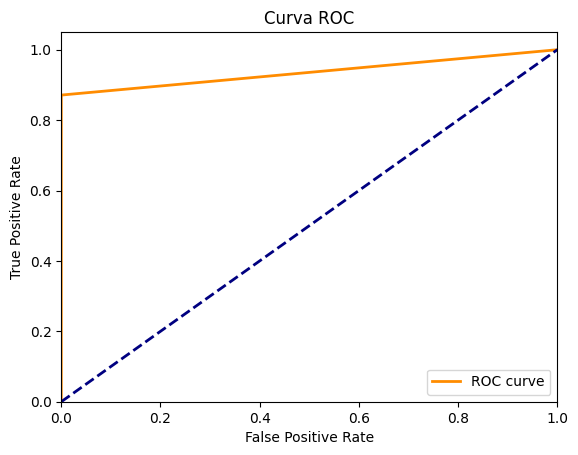

In [85]:
# Fazendo a Plotagem
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

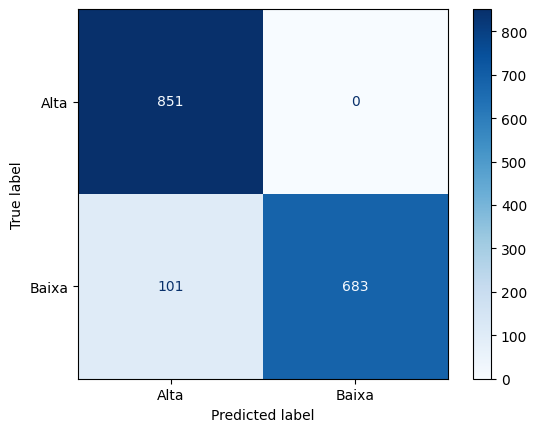

              precision    recall  f1-score   support

        Alta       0.89      1.00      0.94       851
       Baixa       1.00      0.87      0.93       784

    accuracy                           0.94      1635
   macro avg       0.95      0.94      0.94      1635
weighted avg       0.94      0.94      0.94      1635



In [86]:
#Criando a Matriz de Confusao
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
y_pred = (y_probs >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
labels = ['Alta', 'Baixa']
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, y_pred, target_names=labels))

#Avaliando as métricas do modelo LR

## Validação Cruzada


--- Avaliação no Conjunto de Teste ---
AUC - ROC Score: 0.94
Accuracy: 0.94
Precision: 1.00
Recall: 0.87
F1 Score: 0.93

--- Avaliação no Conjunto de Treinamento ---
Accuracy (train): 0.93
Precision (train): 1.00
Recall (train): 0.86
F1 Score (train): 0.93

--- Comparação de Overfitting ---
Accuracy Train: 0.93 | Accuracy Test: 0.94

--- Validação Cruzada (F1 Score) ---
F1 Scores por fold: [0.91 0.92 0.91 0.91 0.89]
F1 Score médio: 0.91
Desvio padrão: 0.01


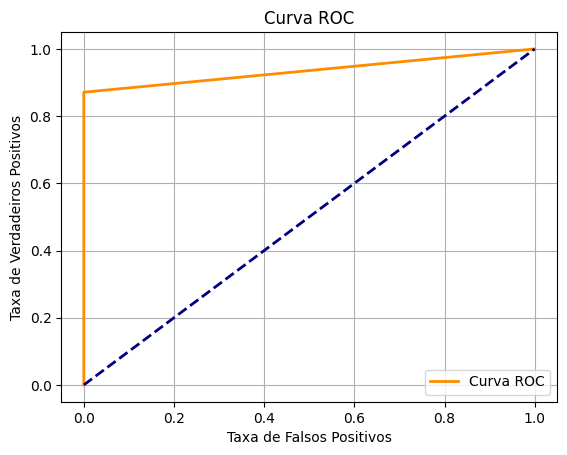

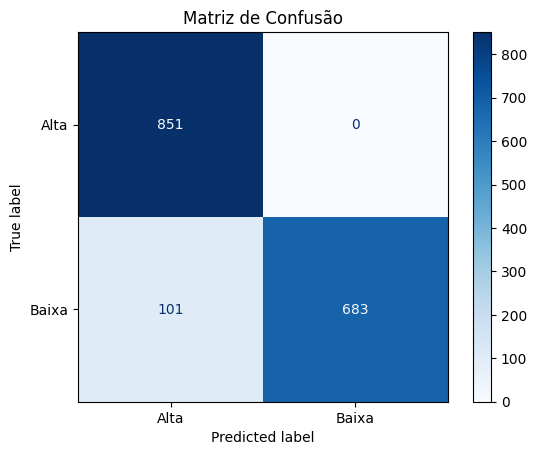


--- Relatório de Classificação ---
              precision    recall  f1-score   support

        Alta       0.89      1.00      0.94       851
       Baixa       1.00      0.87      0.93       784

    accuracy                           0.94      1635
   macro avg       0.95      0.94      0.94      1635
weighted avg       0.94      0.94      0.94      1635



In [87]:
# Importações
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Métricas no TESTE
print("\n--- Avaliação no Conjunto de Teste ---")
print(f"AUC - ROC Score: {roc_auc_score(y_test, y_probs):.2f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")

# Métricas no TREINAMENTO (para overfitting)
y_train_probs = pipeline.predict_proba(x_train)[:, 1]
y_train_pred = (y_train_probs >= 0.5).astype(int)

print("\n--- Avaliação no Conjunto de Treinamento ---")
print(f"Accuracy (train): {accuracy_score(y_train, y_train_pred):.2f}")
print(f"Precision (train): {precision_score(y_train, y_train_pred):.2f}")
print(f"Recall (train): {recall_score(y_train, y_train_pred):.2f}")
print(f"F1 Score (train): {f1_score(y_train, y_train_pred):.2f}")

# Comparação direta
print("\n--- Comparação de Overfitting ---")
print(f"Accuracy Train: {accuracy_score(y_train, y_train_pred):.2f} | Accuracy Test: {accuracy_score(y_test, y_pred):.2f}")

# Validação Cruzada (5-fold com F1 Score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, x_train, y_train, cv=cv, scoring='f1')

print("\n--- Validação Cruzada (F1 Score) ---")
print("F1 Scores por fold:", np.round(cv_scores, 2))
print("F1 Score médio:", np.mean(cv_scores).round(2))
print("Desvio padrão:", np.std(cv_scores).round(2))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
labels = ['Alta', 'Baixa']
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

# Relatório de Classificação
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred, target_names=labels))


In [93]:
#Overfiting
# Avaliação do Modelo no Conjunto de Treinamento
y_train_probs = pipeline.predict(x_train)
y_train_pred = (y_train_probs >= 0.5).astype(int)

# Métricas no Treinamento
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, zero_division=0)
train_recall = recall_score(y_train, y_train_pred, zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, zero_division=0)

print("\n--- Avaliação no Treinamento ---")
print(f"Accuracy (train): {train_accuracy:.2f}")
print(f"Precision (train): {train_precision:.2f}")
print(f"Recall (train): {train_recall:.2f}")
print(f"F1 Score (train): {train_f1:.2f}")


# Comparar com os valores de teste já calculados anteriormente
print("\n--- Comparação Treinamento vs Teste ---")
print(f"Overfitting? -> Accuracy Train: {train_accuracy:.2f} | Accuracy Test: {accuracy:.2f}")
if train_accuracy - accuracy > 0.10:
    print("⚠️ Indício de Overfitting")
else:
    print("✅ Sem evidência forte de overfitting")


--- Avaliação no Treinamento ---
Accuracy (train): 0.93
Precision (train): 1.00
Recall (train): 0.86
F1 Score (train): 0.93

--- Comparação Treinamento vs Teste ---
Overfitting? -> Accuracy Train: 0.93 | Accuracy Test: 0.94
✅ Sem evidência forte de overfitting


## O modelo foi capaz de prever com precisão a tendência e teve boa performace na análise de overfiting.

# Utilizando outros modelos de classificação


In [94]:
#Importando Bibliotecas
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

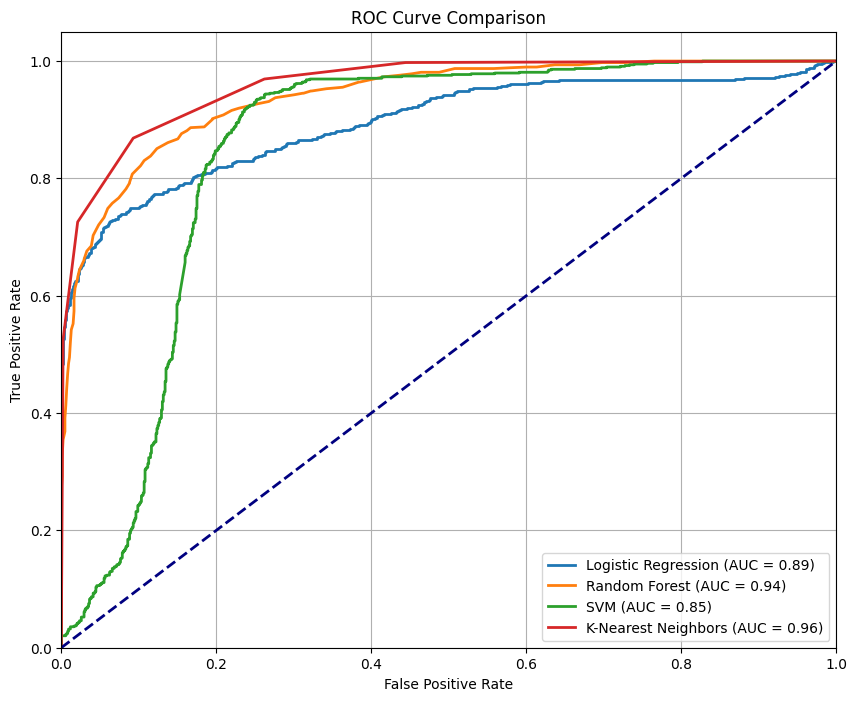


📊 Modelo: Logistic Regression
  - Teste:
    AUC: 0.89
    Accuracy: 0.59
    Precision: 1.00
    Recall: 0.14
    F1: 0.24
  - Treinamento:
    AUC: 0.91
    Accuracy: 0.59
    Precision: 1.00
    Recall: 0.14
    F1: 0.24
  🔍 Overfitting Check (F1): ✅ Sem evidência forte de overfitting

📊 Modelo: Random Forest
  - Teste:
    AUC: 0.94
    Accuracy: 0.86
    Precision: 0.87
    Recall: 0.84
    F1: 0.85
  - Treinamento:
    AUC: 1.00
    Accuracy: 1.00
    Precision: 1.00
    Recall: 1.00
    F1: 1.00
  🔍 Overfitting Check (F1): ⚠️ Indício de Overfitting

📊 Modelo: SVM
  - Teste:
    AUC: 0.85
    Accuracy: 0.75
    Precision: 0.79
    Recall: 0.66
    F1: 0.72
  - Treinamento:
    AUC: 0.87
    Accuracy: 0.76
    Precision: 0.80
    Recall: 0.66
    F1: 0.72
  🔍 Overfitting Check (F1): ✅ Sem evidência forte de overfitting

📊 Modelo: K-Nearest Neighbors
  - Teste:
    AUC: 0.96
    Accuracy: 0.89
    Precision: 0.90
    Recall: 0.87
    F1: 0.88
  - Treinamento:
    AUC: 0.99
    Acc

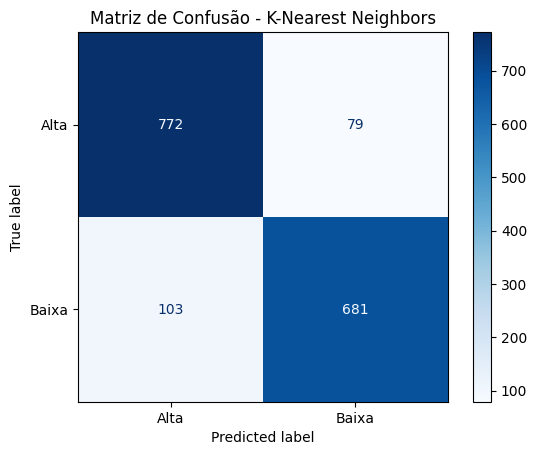

In [95]:
#Definindo os Modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier()
}
#Criando um Dicionario para os scores
roc_auc_scores = {}
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

# Dicionários para guardar scores
metrics_train = {}
metrics_test = {}

#Plotando a Curva
plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(x_train, y_train)

    # ---- TESTE ----
    y_probs_test = model.predict_proba(x_test)[:, 1]
    y_pred_test = (y_probs_test >= 0.5).astype(int)

    test_metrics = {
        'AUC': roc_auc_score(y_test, y_probs_test),
        'Accuracy': accuracy_score(y_test, y_pred_test),
        'Precision': precision_score(y_test, y_pred_test),
        'Recall': recall_score(y_test, y_pred_test),
        'F1': f1_score(y_test, y_pred_test)
    }

    # ---- TREINAMENTO ----
    y_probs_train = model.predict_proba(x_train)[:, 1]
    y_pred_train = (y_probs_train >= 0.5).astype(int)

    train_metrics = {
        'AUC': roc_auc_score(y_train, y_probs_train),
        'Accuracy': accuracy_score(y_train, y_pred_train),
        'Precision': precision_score(y_train, y_pred_train),
        'Recall': recall_score(y_train, y_pred_train),
        'F1': f1_score(y_train, y_pred_train)
    }

    # Salvando métricas
    metrics_test[name] = test_metrics
    metrics_train[name] = train_metrics

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_probs_test)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {test_metrics["AUC"]:.2f})')

# Linha diagonal de referência
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Impressão de métricas
for name in models.keys():
    print(f"\n📊 Modelo: {name}")
    print("  - Teste:")
    for k, v in metrics_test[name].items():
        print(f"    {k}: {v:.2f}")
    print("  - Treinamento:")
    for k, v in metrics_train[name].items():
        print(f"    {k}: {v:.2f}")
    print("  🔍 Overfitting Check (F1):", end=" ")
    train_f1 = metrics_train[name]['F1']
    test_f1 = metrics_test[name]['F1']
    if train_f1 - test_f1 > 0.10:
        print("⚠️ Indício de Overfitting")
    else:
        print("✅ Sem evidência forte de overfitting")

# Matriz de confusão do melhor modelo em termos de F1 Score no teste
best_model_name = max(metrics_test, key=lambda m: metrics_test[m]['F1'])
print(f"\n🏆 Melhor modelo com base no F1 Score de teste: {best_model_name}")

# Reajuste para obter a matriz de confusão
best_model = models[best_model_name]
y_probs_best = best_model.predict_proba(x_test)[:, 1]
y_pred_best = (y_probs_best >= 0.5).astype(int)

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_best)
labels = ['Alta', 'Baixa']
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot(cmap=plt.cm.Blues)
plt.title(f"Matriz de Confusão - {best_model_name}")
plt.show()

## Analisando os modelos, podemos observar que o modelo KNN obteve melhor performace preditiva, com acuracia de 89%. Contudo, a acurácia desse modelo foi menor do que o primeiro modelo de regressão logística que treinamos. Acreditamos que esse resultado pode ter ocorrido em razão da limitação do número de iterações.